## Setting Environment

In [17]:
import csv, math, random, statistics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pygad
from tqdm.notebook import tqdm
import time

from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

######################
### Experiment paramter
######################

M = 10                  # Marco-Replications
N = 10                  # Undersamples
K = 10                  # post-replication
R = 2                   # Ratio of defects:non-defects (1:p)
BETA_LIST = [1,2,3,4]   # Beta values for F-scores
R_0 = 54                # Imbalance ratio

np.random.seed(123)
SEED_M = np.random.choice(range(1000), M)

######################
### LASSO paramter
######################
alphaGrid = [0.01, 0.1, 1]
tol = 1e-2

######################
### GA paramter
######################
POP_SIZE = 10           # GA Parameter: Population Size
P_CROSSOVER = 0.8       # GA Parameter: Probability of a Crossover
P_MUTATION = 0.2        # GA Parameter: Probability of a Mutation
MAX_ITER = 30           # GA Parameter: Maximum Iterations

######################
### cut off value for feature selection
######################
q = 0.33

EN_threshold = q
SOEN_threshold = q

def optimalThreshold_Gmeans(yTest, yPredProba):
    
    fpr, tpr, thresholds = roc_curve(yTest, yPredProba)
    gmeans = np.sqrt(tpr * (1-fpr))
    optThreshIndex = gmeans.argmax()
    optThresh = thresholds[optThreshIndex]
    return optThresh

## Load Dataset

In [18]:
temp_data = pd.read_csv("Modeling_Dataset_2.csv", sep = ",")
layerDF = pd.DataFrame(data = temp_data.values, columns = temp_data.columns)
layerDF.rename(columns = {"Response": "y"}, inplace = True)
layerDF = layerDF.iloc[:,1:] # drop ID
sc = MinMaxScaler()
layerDF.iloc[:,1:] = sc.fit_transform(layerDF.iloc[:,1:])
layerDF = layerDF[layerDF.columns[(layerDF.var() != 0).values]]
var_list = layerDF.columns[1:]
layerDF[var_list] = layerDF[var_list].astype("float")
layerDF.head()

,y,PreHeat_SDC_gt40_Count_Last,PreHeat_SDC_gt40_Count_Last2,PreHeat_SDC_gt40_Count_Last5,PreHeat_SDC_gt40_Binary_Last,PreHeat_SDC_gt40_Binary_Last2,PreHeat_SDC_gt40_Binary_Last5,Melt_SDC_gt40_Count_Last,Melt_SDC_gt40_Count_Last2,Melt_SDC_gt40_Count_Last5,...,BVG_max_Last,BVG_max_Last2,BVG_max_Last5,BVG_min_Last,BVG_min_Last2,BVG_min_Last5,BVG_Mean_Last,BVG_Mean_Last2,BVG_Mean_Last5,BVG_Var_Last
0,0,0.2,0.285714,0.454545,1.0,1.0,1.0,0.125,0.250000,0.434783,...,0.333333,0.333333,0.333333,0.763127,0.763127,0.763127,0.541317,0.849509,0.629270,0.012871
1,0,0.0,0.142857,0.363636,0.0,1.0,1.0,0.125,0.166667,0.391304,...,0.333333,0.333333,0.333333,0.763127,0.763127,0.763127,0.540021,0.849432,0.650682,0.013476
2,0,0.0,0.000000,0.272727,0.0,0.0,1.0,0.375,0.333333,0.478261,...,0.333333,0.333333,0.333333,0.763127,0.763127,0.763127,0.525964,0.846793,0.648757,0.016032
3,0,0.0,0.000000,0.181818,0.0,0.0,1.0,0.125,0.333333,0.304348,...,0.333333,0.333333,0.333333,0.763127,0.763127,0.763127,0.528180,0.844873,0.646049,0.015741
4,0,0.0,0.000000,0.090909,0.0,0.0,1.0,0.125,0.166667,0.260870,...,0.333333,0.333333,0.333333,0.763127,0.763127,0.763127,0.520723,0.844016,0.642860,0.016963


## Table-1 (~ 30 sec)

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import StratifiedKFold

import imblearn

names = [
    "Linear SVM",
    "RBF SVM",
    "KNN",
    "Decision Tree",
    "AdaBoost",
    "Random Forest",
    "ExtraTrees",
    "Gaussian Process",
    "Naive Bayes",
    "QDA",
    "Neural Net",
    "LightGBM",
    "Logistic Regression",
    "LASSO",
    "RIDGE",   
]

classifiers = [
    SVC(kernel = "linear", random_state = 0),
    SVC(random_state = 0),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state = 0),
    AdaBoostClassifier(random_state = 0),
    
    RandomForestClassifier(random_state = 0), 
    ExtraTreesClassifier(random_state = 0),
    GaussianProcessClassifier(random_state = 0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    
    MLPClassifier(random_state = 0),
    LGBMClassifier(random_state = 0),
    LogisticRegression(random_state= 0),
    Lasso(random_state = 0, alpha = 0.01),
    Ridge(random_state = 0)
]

result_f1 = []
result_f2 = []
result_f3 = []
result_f4 = []
result_prec = []
result_rec = []

var_list = layerDF.columns[1:]

n_fold = 5

for name, clf in zip(names, classifiers):
    skf = StratifiedKFold(n_splits = n_fold)
    X, y = layerDF[var_list], layerDF["y"].astype("int")
    skf.get_n_splits(X, y)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = list(y[train_index]), list(y[test_index])
        
        res = imblearn.over_sampling.SMOTE(random_state = 0)
        X_train_over, y_train_over = res.fit_resample(X_train, y_train)
    
        clf.fit(X_train_over, y_train_over)
        
        if name in ["Logistic Regression", "LASSO", "RIDGE"]:
            temp_pred = clf.predict(X_train_over)
            opt_threshold = optimalThreshold_Gmeans(y_train_over, temp_pred)
            
            pred = clf.predict(X_test)
            pred = list(map(bool, pred >= opt_threshold))
        
        else:
            pred = clf.predict(X_test)
        
        result_f1.append(fbeta_score(y_test, pred, beta = 1))
        result_f2.append(fbeta_score(y_test, pred, beta = 2))
        result_f3.append(fbeta_score(y_test, pred, beta = 3))
        result_f4.append(fbeta_score(y_test, pred, beta = 4))
        
        result_prec.append(precision_score(y_test, pred))
        result_rec.append(recall_score(y_test, pred))
        
df = [list(np.array(result_rec).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_prec).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_f1).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_f2).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_f3).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_f4).reshape(15,n_fold).mean(axis = 1))]

df = np.around(df, 4).T

df = pd.DataFrame(np.array(df),
                 columns = ["Recall",
                          "Precision",
                          "F-score (beta = 1)", 
                          "F-score (beta = 2)", 
                          "F-score (beta = 3)", 
                          "F-score (beta = 4)"],
             index = names)
df

,Recall,Precision,F-score (beta = 1),F-score (beta = 2),F-score (beta = 3),F-score (beta = 4)
Linear SVM,0.0667,0.0400,0.0500,0.0588,0.0625,0.0642
RBF SVM,0.1333,0.2182,0.1286,0.1204,0.1241,0.1270
KNN,0.4000,0.2242,0.2040,0.2294,0.2664,0.2974
Decision Tree,0.0667,0.0083,0.0148,0.0278,0.0392,0.0472
AdaBoost,0.0667,0.0036,0.0069,0.0149,0.0244,0.0330
Random Forest,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ExtraTrees,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Gaussian Process,0.2667,0.2322,0.1555,0.1748,0.2029,0.2224
Naive Bayes,0.4000,0.2445,0.1724,0.2009,0.2432,0.2791
QDA,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## Phase-1 (~ 25 min)

In [126]:
neg_where = list(np.where(layerDF["y"] == 0)[0])
pos_where = list(np.where(layerDF["y"] == 1)[0])

All_feat_EN = []
All_feat_SOEN_OOB = []
All_feat_SOEN_NOOB = []
All_feat_CRUDE = []

##################
### Beta-iter  ###
##################
for i0 in tqdm(range(len(BETA_LIST)), position = 0, desc = "Beta", leave = False, colour = 'red'):
    beta = BETA_LIST[i0]
    
    ##################
    ### Macro-iter ###
    ##################
    for i1 in tqdm(range(M), position = 1, desc = "Macro", leave = False, colour = 'blue'):
        temp_neg_where = neg_where.copy()
        temp_pos_where = pos_where.copy()
        
        np.random.seed(SEED_M[i1])
        np.random.shuffle(temp_neg_where)
        np.random.shuffle(temp_pos_where)
        
        train_pos_where, test_pos_where = np.array_split(temp_pos_where, 2)
        train_neg_where = np.random.choice(temp_neg_where, len(train_pos_where) * R, replace = True)
        
        X_train = layerDF.loc[list(train_pos_where) + list(train_neg_where)]
        X_train = X_train[var_list]
        y_train = list(layerDF["y"][list(train_pos_where) + list(train_neg_where)])
        
        if i0 == 0:
            #############
            ### CRUDE LASSO
            #############
            reg = LassoCV(alphas = alphaGrid, tol = tol).fit(X_train,y_train)
            coef = pd.Series(reg.coef_, index = var_list, name = "Sel")
            pred_train = reg.predict(X_train)
            opt_threshold = optimalThreshold_Gmeans(y_train, pred_train)
            All_feat_CRUDE.append(list(coef[coef!=0].index.values))
        
        ##################
        ### Micro-iter ###
        ##################
        all_temp_neg_where_train = []
        all_temp_pos_where_train = []

        all_temp_neg_where_test = []
        all_temp_pos_where_test = []
        
        for i2 in tqdm(range(N), position = 2, desc = 'Micro', leave = False, colour = 'green'):
            temp_neg_where = neg_where.copy()
            temp_pos_where = pos_where.copy()
            
            np.random.seed(SEED_M[i1])
            SEED_K = np.random.choice(range(1000), N)
            np.random.seed(SEED_K[i2])
            np.random.shuffle(temp_neg_where)
            np.random.shuffle(temp_pos_where)
            
            #############
            ### EN
            #############
            
            train_pos_where, test_pos_where = np.array_split(temp_pos_where, 2)
            train_neg_where = np.random.choice(temp_neg_where, len(train_pos_where) * R, replace = True)
            
            X_train = layerDF.loc[list(train_pos_where) + list(train_neg_where)]
            X_train = X_train[var_list]
            y_train = list(layerDF["y"][list(train_pos_where) + list(train_neg_where)])
            
            if i0 == 0:
                reg = LassoCV(alphas = alphaGrid, tol = tol).fit(X_train, y_train)
                coef = pd.Series(reg.coef_, index = var_list, name = "Sel")
                pred_train = reg.predict(X_train)
                opt_threshold = optimalThreshold_Gmeans(y_train, pred_train)
                All_feat_EN.append(list(coef[coef!=0].index.values))
        
            #############
            ### SOEN sampling
            #############

            all_temp_neg_where_train.append(list(train_neg_where))
            all_temp_pos_where_train.append(list(train_pos_where))

            all_temp_neg_where_test.append(np.random.choice(list(set(neg_where) - set(train_neg_where)),
                                                            len(test_pos_where) * R_0, replace = True))
            
            all_temp_pos_where_test.append(list(set(pos_where) - set(train_pos_where)))
        
        #############
        ### SOEN with OOB
        #############
        
        def fitness_func(solution, solution_idx):

            temp_var = var_list[solution == 1]
            temp_scores = []
            
            for i0 in range(N):
                temp_X_train = layerDF.loc[list(all_temp_neg_where_train[i0]) + list(all_temp_pos_where_train[i0])]
                temp_y_train = list(layerDF["y"][list(all_temp_neg_where_train[i0]) + list(all_temp_pos_where_train[i0])])
                temp_model = LassoCV(alphas = alphaGrid, tol = tol).fit(temp_X_train[temp_var], temp_y_train)
                
                coef = pd.Series(temp_model.coef_, index = temp_var, name = "Sel")
                
                if np.max(np.abs(coef)) == 0:
                    temp_scores.append(0)
                else:
                    
                    pred_train = temp_model.predict(temp_X_train[temp_var])
                    
                    opt_threshold = optimalThreshold_Gmeans(temp_y_train, pred_train)
                    
                    temp_X_test = layerDF.loc[list(all_temp_neg_where_test[i0]) + list(all_temp_pos_where_test[i0])]
                    temp_y_test = list(layerDF["y"][list(all_temp_neg_where_test[i0]) + list(all_temp_pos_where_test[i0])])
                    
                    temp_pred = temp_model.predict(temp_X_test[temp_var])
                    temp_pred = list(map(bool, temp_pred >= opt_threshold))

                    # beta score 0 - 1, higher the better
                    temp_score = fbeta_score(temp_y_test, temp_pred, beta = beta)
                    temp_scores.append(temp_score)
            
            return np.mean(temp_scores)

        ga_instance = pygad.GA(num_generations = MAX_ITER,
                               sol_per_pop = POP_SIZE,
                               crossover_probability = P_CROSSOVER,
                               mutation_probability = P_MUTATION,
                               num_parents_mating = 2,
                               num_genes=len(var_list),
                               fitness_func=fitness_func,
                               mutation_type="swap",
                               init_range_low=0,
                               init_range_high=2,
                               gene_type=int,
                               random_seed = i0)

        ga_instance.run()
        
        SOEN_var = list(var_list[ga_instance.best_solution()[0] == 1])
        
        for i2 in range(N):
            temp_X_train = layerDF.loc[list(all_temp_neg_where_train[i2]) + list(all_temp_pos_where_train[i2])]
            temp_y_train = list(layerDF["y"][list(all_temp_neg_where_train[i2]) + list(all_temp_pos_where_train[i2])])
            temp_model = LassoCV(alphas = alphaGrid, tol = tol).fit(temp_X_train[SOEN_var], temp_y_train)
                
            coef = pd.Series(temp_model.coef_, index = SOEN_var, name = "Sel")
        
            All_feat_SOEN_OOB.append(list(coef[coef!=0].index.values))
        
        #############
        ### SOEN with NOOB
        #############
            
        def fitness_func2(solution, solution_idx):

            temp_var = var_list[solution == 1]
            temp_scores = []
            
            for i0 in range(N):
                temp_X_train = layerDF.loc[list(all_temp_neg_where_train[i0]) + list(all_temp_pos_where_train[i0])]
                temp_y_train = list(layerDF["y"][list(all_temp_neg_where_train[i0]) + list(all_temp_pos_where_train[i0])])
                temp_model = LassoCV(alphas = alphaGrid, tol = tol).fit(temp_X_train[temp_var], temp_y_train)
                
                coef = pd.Series(temp_model.coef_, index = temp_var, name = "Sel")
                
                if np.max(np.abs(coef)) == 0:
                    temp_scores.append(0)
                else:
                    
                    pred_train = temp_model.predict(temp_X_train[temp_var])
                    
                    opt_threshold = optimalThreshold_Gmeans(temp_y_train, pred_train)
                    
                    temp_pred = temp_model.predict(temp_X_train[temp_var])
                    temp_pred = list(map(bool, temp_pred >= opt_threshold))

                    # beta score 0 - 1, higher the better
                    temp_score = fbeta_score(temp_y_train, temp_pred, beta = beta)
                    temp_scores.append(temp_score)
            
            return np.mean(temp_scores)
        
        ga_instance = pygad.GA(num_generations = MAX_ITER,
                               sol_per_pop = POP_SIZE,
                               crossover_probability = P_CROSSOVER,
                               mutation_probability = P_MUTATION,
                               num_parents_mating = 2,
                               num_genes=len(var_list),
                               fitness_func=fitness_func2,
                               mutation_type="swap",
                               init_range_low=0,
                               init_range_high=2,
                               gene_type=int,
                               random_seed = i0)
        
        ga_instance.run()
        
        SOEN_var = list(var_list[ga_instance.best_solution()[0] == 1])
        
        for i2 in range(N):
            temp_X_train = layerDF.loc[list(all_temp_neg_where_train[i2]) + list(all_temp_pos_where_train[i2])]
            temp_y_train = list(layerDF["y"][list(all_temp_neg_where_train[i2]) + list(all_temp_pos_where_train[i2])])
            temp_model = LassoCV(alphas = alphaGrid, tol = tol).fit(temp_X_train[SOEN_var], temp_y_train)
                
            coef = pd.Series(temp_model.coef_, index = SOEN_var, name = "Sel")
        
            All_feat_SOEN_NOOB.append(list(coef[coef!=0].index.values))

Beta:   0%|          | 0/4 [00:00<?, ?it/s]

Macro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Macro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Macro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Macro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

Micro:   0%|          | 0/10 [00:00<?, ?it/s]

## Phase-2 (~ 1 min)

In [128]:
neg_where = list(np.where(layerDF["y"] == 0)[0])
pos_where = list(np.where(layerDF["y"] == 1)[0])


all_result = []
varvar_list = []

K = 10

for ii in tqdm(range(4), position = 0, desc = "Beta", leave = False, colour = 'black'):
    
    for i0 in tqdm(range(M), position = 1, desc = "Macro", leave = False, colour = 'red'):

        for i1 in tqdm(range(K), position = 2, desc = "Repli", leave = False, colour = 'blue'):
            temp_neg_where = neg_where.copy()
            temp_pos_where = pos_where.copy()

            np.random.seed(SEED_M[i0])
            SEED_K = np.random.choice(range(1000), K)
            np.random.seed(SEED_K[i1])

            np.random.shuffle(temp_neg_where)
            np.random.shuffle(temp_pos_where)

            train_pos_where, test_pos_where = np.array_split(temp_pos_where, 2)
            train_neg_where = np.random.choice(temp_neg_where, len(train_pos_where) * R, replace = True)

            X_train = layerDF.loc[list(train_pos_where) + list(train_neg_where)]
            y_train = list(layerDF["y"][list(train_pos_where) + list(train_neg_where)])

            R_0 = int(len(neg_where)/len(pos_where))

            test_neg_where = np.random.choice(list(set(neg_where) - set(np.array(train_neg_where).ravel())),
                                          len(test_pos_where) * R_0, replace = True)

            X_test = layerDF.loc[list(test_neg_where) + list(test_pos_where)]
            y_test = list(layerDF["y"][list(test_neg_where) + list(test_pos_where)])


            for i2 in tqdm(range(10), position = 3, desc = "method", leave = False, colour = 'green'):
                if i2 == 0:
                    varvar = All_feat_CRUDE[i0]

                if i2 == 1:
                    EN_table = np.unique(sum(list(np.array(All_feat_EN).reshape(M, N)[i0,:]), []), return_counts = True)
                    varvar = EN_table[0][EN_table[1] >= N*EN_threshold]

                if i2 in list([2,3,4,5]):
                    SOEN_OOB_table = np.unique(sum(list(np.array(All_feat_SOEN_OOB).reshape(4, M, N)[i2-2, i0, :]), []), return_counts = True)
                    varvar = SOEN_OOB_table[0][SOEN_OOB_table[1] >= N*SOEN_threshold]
                    
                if i2 in list([6,7,8,9]):
                    SOEN_NOOB_table = np.unique(sum(list(np.array(All_feat_SOEN_NOOB).reshape(4, M, N)[i2-6, i0, :]), []), return_counts = True)
                    varvar = SOEN_NOOB_table[0][SOEN_NOOB_table[1] >= N*SOEN_threshold]

                if len(varvar) == 0:
                    all_result.append(0)
                    varvar_list.append(0)
                    
                else:
                    reg = LogisticRegression()
                    
                    reg.fit(X_train[varvar], y_train)
                    pred_train = reg.predict(X_train[varvar])
                    opt_threshold = optimalThreshold_Gmeans(y_train, pred_train)
                    temp_pred = reg.predict(X_test[varvar])
                    temp_pred = list(map(bool, temp_pred >= opt_threshold))

                    temp_score = confusion_matrix(y_test, temp_pred)
                    all_result.append(temp_score)
                    varvar_list.append(varvar)

Beta:   0%|          | 0/4 [00:00<?, ?it/s]

Macro:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Macro:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Macro:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Macro:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

Repli:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

method:   0%|          | 0/10 [00:00<?, ?it/s]

## Table-4

In [163]:
import sklearn
all_result_mat = np.array(all_result).reshape(4,M,K,10)
all_result_rec = []
all_result_prec = []
all_result_fbeta = []

for i0 in range(4):
    for i1 in range(M):
        for i2 in range(K):
            for i3 in range(10):
                temp_mat = all_result_mat[i0,i1,i2,i3]
                if np.sum(temp_mat) == 0:
                    all_result_rec.append(0)
                    all_result_prec.append(0)
                    all_result_fbeta.append(0)
                else:
                    tn = temp_mat[0,0]
                    tp = temp_mat[1,1]
                    fn = temp_mat[1,0]
                    fp = temp_mat[0,1]
                    
                    all_result_rec.append((tp)/(tp+fn))
                    all_result_prec.append((tp)/(tp+fp))
                    beta = i0 + 1
                    
                    all_result_fbeta.append(tp / (tp + (beta**2/(1+beta**2)) + (1/(1+beta**2))*fp))
                    
means_rec = np.array(all_result_rec).reshape(4,M,K,10).mean(axis = (1,2))
all_result_prec = np.array(all_result_prec)
all_result_prec[np.isnan(all_result_prec)] = 0
means_prec = np.array(all_result_prec).reshape(4,M,K,10).mean(axis = (1,2))
means_fbeta = np.array(all_result_fbeta).reshape(4,M,K,10).mean(axis = (1,2))

all_var_mat = np.array(varvar_list).reshape(4,M,K,10)
temp_var_len = []
for i0 in range(4):
    for i1 in range(M):
        for i2 in range(K):
            for i3 in range(10):
                temp_mat = all_var_mat[i0,i1,i2,i3]
                if temp_mat == 0:
                    temp_var_len.append(0)
                else:
                    temp_var_len.append(len(temp_mat))

temp = np.core.defchararray.add(np.around(means_fbeta[:,2:], 3).astype("str"), u"\u00B1")
temp = np.core.defchararray.add(temp, np.around(np.array((np.array(all_result_fbeta).reshape(4,M,K,10).mean(axis = (2)).var(axis = 1, ddof = 1) ** 0.5) * 1.96 / (10 ** 0.5))[:,2:], 3).astype("str"))

temp1 = np.core.defchararray.add(np.around(means_rec[0,2:], 3).astype("str"), u"\u00B1")
temp1 = np.core.defchararray.add(temp1, np.around((np.array(all_result_rec).reshape(4,M,K,10).mean(axis = 2).var(axis = 1, ddof = 1) ** 0.5) * 1.96 / (10 ** 0.5), 3)[0, 2:].astype("str"))

temp2 = np.core.defchararray.add(np.around(means_prec[0,2:], 3).astype("str"), u"\u00B1")
temp2 = np.core.defchararray.add(temp2, np.around((np.array(all_result_prec).reshape(4,M,K,10).mean(axis = 2).var(axis = 1, ddof = 1) ** 0.5) * 1.96 / (10 ** 0.5), 3)[0, 2:].astype("str"))
temp3 = np.array(temp_var_len).reshape(4,M,K,10).mean(axis = (1,2))[0,2:]
df = temp
df = np.vstack((df, temp1))
df = np.vstack((df, temp2))
df = np.vstack((df, temp3))
df = df[:,list([0,4,1,5,2,6,3,7])]

df = pd.DataFrame(df, 
                 index = ["F-score (beta = 1)", 
                          "F-score (beta = 2)", 
                          "F-score (beta = 3)", 
                          "F-score (beta = 4)",
                          "Recall",
                          "Precision",
                         "Avg. # of features"],
             columns = ["OOB (SOEN-1)", "NOOB (SOEN-1)", "OOB (SOEN-2)", "NOOB (SOEN-2)",
                       "OOB (SOEN-3)", "NOOB (SOEN-3)", "OOB (SOEN-4)", "NOOB (SOEN-4)"])
df

,OOB (SOEN-1),NOOB (SOEN-1),OOB (SOEN-2),NOOB (SOEN-2),OOB (SOEN-3),NOOB (SOEN-3),OOB (SOEN-4),NOOB (SOEN-4)
F-score (beta = 1),0.119±0.024,0.117±0.02,0.115±0.022,0.111±0.017,0.096±0.026,0.12±0.026,0.115±0.028,0.122±0.015
F-score (beta = 2),0.227±0.04,0.231±0.036,0.225±0.037,0.219±0.029,0.19±0.049,0.222±0.026,0.218±0.04,0.239±0.025
F-score (beta = 3),0.334±0.051,0.345±0.05,0.336±0.047,0.327±0.037,0.286±0.069,0.325±0.027,0.321±0.049,0.356±0.03
F-score (beta = 4),0.418±0.057,0.435±0.059,0.425±0.053,0.415±0.043,0.364±0.083,0.409±0.032,0.403±0.053,0.448±0.032
Recall,0.506±0.034,0.517±0.05,0.517±0.046,0.464±0.062,0.457±0.078,0.45±0.066,0.496±0.063,0.491±0.035
Precision,0.068±0.015,0.065±0.012,0.064±0.013,0.062±0.011,0.053±0.015,0.071±0.022,0.066±0.019,0.067±0.009
Avg. # of features,6.2,9.4,5.5,9.7,5.0,10.5,5.1,10.2


## Table 5

In [164]:
temp = np.core.defchararray.add(np.around(means_fbeta[:,:6], 3).astype("str"), u"\u00B1")
temp = np.core.defchararray.add(temp, np.around(np.array((np.array(all_result_fbeta).reshape(4,M,K,10).mean(axis = (2)).var(axis = 1, ddof = 1) ** 0.5) * 1.96 / (10 ** 0.5))[:,:6], 3).astype("str"))

df = pd.DataFrame(temp,
                 index = ["Beta = 1", "Beta = 2", "Beta = 3", "Beta = 4"],
                 columns = ["CRUDE", "EN", "SOEN-1", "SOEN-2", "SOEN-3", "SOEN-4"])
df

,CRUDE,EN,SOEN-1,SOEN-2,SOEN-3,SOEN-4
Beta = 1,0.041±0.031,0.08±0.029,0.119±0.024,0.115±0.022,0.096±0.026,0.115±0.028
Beta = 2,0.084±0.062,0.164±0.057,0.227±0.04,0.225±0.037,0.19±0.049,0.218±0.04
Beta = 3,0.128±0.094,0.253±0.085,0.334±0.051,0.336±0.047,0.286±0.069,0.321±0.049
Beta = 4,0.165±0.118,0.327±0.107,0.418±0.057,0.425±0.053,0.364±0.083,0.403±0.053


## Table 6

In [190]:
temp = np.core.defchararray.add(np.around(means_fbeta[:,list([0,1,3])], 3).T.astype("str"), u"\u00B1")
temp = np.core.defchararray.add(temp, np.around(np.array((np.array(all_result_fbeta).reshape(4,M,K,10).mean(axis = (2)).var(axis = 1, ddof = 1) ** 0.5) * 1.96 / (10 ** 0.5))[:,list([0,1,3])], 3).astype("str").T)

temp1 = np.core.defchararray.add(np.around(means_prec[0,list([0,1,3])], 3).astype("str"), u"\u00B1")
temp1 = np.core.defchararray.add(temp1, np.around((np.array(all_result_prec).reshape(4,M,K,10).mean(axis = 2).var(axis = 1, ddof = 1) ** 0.5) * 1.96 / (10 ** 0.5), 3)[0, list([0,1,3])].astype("str"))

temp2 = np.core.defchararray.add(np.around(means_rec[0,list([0,1,3])], 3).astype("str"), u"\u00B1")
temp2 = np.core.defchararray.add(temp2, np.around((np.array(all_result_rec).reshape(4,M,K,10).mean(axis = 2).var(axis = 1, ddof = 1) ** 0.5) * 1.96 / (10 ** 0.5), 3)[0, list([0,1,3])].astype("str"))

temp = np.hstack((temp, temp1.reshape(-1,1)))
temp = np.hstack((temp, temp2.reshape(-1,1)))
temp = np.hstack((temp, np.array(temp_var_len).reshape(4,M,K,10).mean(axis = (1,2))[0,list([0,1,3])].reshape(-1,1)))

df = pd.DataFrame(temp,
                 columns = ["F-1 score", "F-2 score", "F-3 score", "F-4 score", "Recall", "Precision", "Avg Feats"],
                  index = ["CRUDE", "EN", "SOEN-2"])
df

,F-1 score,F-2 score,F-3 score,F-4 score,Recall,Precision,Avg Feats
CRUDE,0.041±0.031,0.084±0.062,0.128±0.094,0.165±0.118,0.022±0.017,0.234±0.149,3.3
EN,0.08±0.029,0.164±0.057,0.253±0.085,0.327±0.107,0.043±0.016,0.479±0.132,3.9
SOEN-2,0.115±0.022,0.225±0.037,0.336±0.047,0.425±0.053,0.064±0.013,0.517±0.046,5.5


## Figure 11

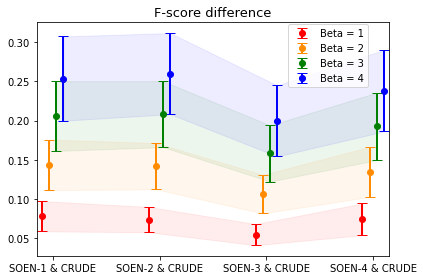

In [192]:
diff_mean = []
diff_ci = []
for i0 in range(4): # beta 1 2 3 4
    for i1 in range(4): # soen 1 2 3 4
        diff_mean.append(np.mean(np.array(all_result_fbeta).reshape(4,M,K,10)[i0,:,:,i1 + 2].ravel() - np.array(all_result_fbeta).reshape(4,M,K,10)[i0,:,:,0].ravel()))
        diff_ci.append((np.var(np.array(all_result_fbeta).reshape(4,M,K,10)[i0,:,:,i1 + 2].ravel() - np.array(all_result_fbeta).reshape(4,M,K,10)[i0,:,:,0].ravel(), ddof = 1) ** 0.5)*1.96/(10))
diff_mean = np.array(diff_mean).reshape(4,4)
diff_ci = np.array(diff_ci).reshape(4,4)

from matplotlib.transforms import ScaledTranslation

xx = list(["SOEN-1 & CRUDE","SOEN-2 & CRUDE","SOEN-3 & CRUDE","SOEN-4 & CRUDE"])
fig, ax = plt.subplots()

trans1 = ax.transData + ScaledTranslation(-0.15, 0, fig.dpi_scale_trans)
trans2 = ax.transData + ScaledTranslation(-0.05, 0, fig.dpi_scale_trans)
trans3 = ax.transData + ScaledTranslation(0.05, 0, fig.dpi_scale_trans)
trans4 = ax.transData + ScaledTranslation(0.15, 0, fig.dpi_scale_trans)

lw_size = 2
plt_alpha = 0.07
p1 = ax.errorbar(xx, diff_mean[0,:], diff_ci[0,:], linestyle = "none", transform = trans1,
                 label = "Beta = 1", marker = 'o', capsize = 5, lw = lw_size, color = "red")

ax.fill_between(xx, diff_mean[0,:] - diff_ci[0,:], diff_mean[0,:] + diff_ci[0,:], alpha = plt_alpha, color = "red", transform = trans1)

p2 = ax.errorbar(xx, diff_mean[1,:], diff_ci[1,:], linestyle = "none", transform = trans2,
                 label = "Beta = 2", marker = 'o', capsize = 5, lw = lw_size, color = "darkorange")

ax.fill_between(xx, diff_mean[1,:] - diff_ci[1,:], diff_mean[1,:] + diff_ci[1,:], alpha = plt_alpha, color = "darkorange", transform = trans2)

p3 = ax.errorbar(xx, diff_mean[2,:], diff_ci[2,:], linestyle = "none", transform = trans3,
                 label = "Beta = 3", marker = 'o', capsize = 5, lw = lw_size, color = "green")

ax.fill_between(xx, diff_mean[2,:] - diff_ci[2,:], diff_mean[2,:] + diff_ci[2,:], alpha = plt_alpha, color = "green", transform = trans3)

p4 = ax.errorbar(xx, diff_mean[3,:], diff_ci[3,:], linestyle = "none", transform = trans4,
                 label = "Beta = 4", marker = 'o', capsize = 5, lw = lw_size, color = "blue")

ax.fill_between(xx, diff_mean[3,:] - diff_ci[3,:], diff_mean[3,:] + diff_ci[3,:], alpha = plt_alpha, color = "blue", transform = trans4)

handles, labels = ax.get_legend_handles_labels()
plt.title("F-score difference", fontsize = 13)
ax.legend(bbox_to_anchor=(0.7, 0.7))
fig.tight_layout()
plt.show()

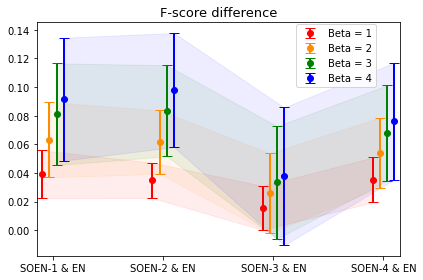

In [193]:
diff_mean = []
diff_ci = []
for i0 in range(4): # beta 1 2 3 4
    for i1 in range(4): # soen 1 2 3 4
        diff_mean.append(np.mean(np.array(all_result_fbeta).reshape(4,M,K,10)[i0,:,:,i1 + 2].ravel() - np.array(all_result_fbeta).reshape(4,M,K,10)[i0,:,:,1].ravel()))
        diff_ci.append((np.var(np.array(all_result_fbeta).reshape(4,M,K,10)[i0,:,:,i1 + 2].ravel() - np.array(all_result_fbeta).reshape(4,M,K,10)[i0,:,:,1].ravel(), ddof = 1) ** 0.5)*1.96/(10))
diff_mean = np.array(diff_mean).reshape(4,4)
diff_ci = np.array(diff_ci).reshape(4,4)

from matplotlib.transforms import ScaledTranslation

xx = list(["SOEN-1 & EN","SOEN-2 & EN","SOEN-3 & EN","SOEN-4 & EN"])
fig, ax = plt.subplots()

trans1 = ax.transData + ScaledTranslation(-0.15, 0, fig.dpi_scale_trans)
trans2 = ax.transData + ScaledTranslation(-0.05, 0, fig.dpi_scale_trans)
trans3 = ax.transData + ScaledTranslation(0.05, 0, fig.dpi_scale_trans)
trans4 = ax.transData + ScaledTranslation(0.15, 0, fig.dpi_scale_trans)

lw_size = 2
plt_alpha = 0.07
p1 = ax.errorbar(xx, diff_mean[0,:], diff_ci[0,:], linestyle = "none", transform = trans1,
                 label = "Beta = 1", marker = 'o', capsize = 5, lw = lw_size, color = "red")

ax.fill_between(xx, diff_mean[0,:] - diff_ci[0,:], diff_mean[0,:] + diff_ci[0,:], alpha = plt_alpha, color = "red", transform = trans1)

p2 = ax.errorbar(xx, diff_mean[1,:], diff_ci[1,:], linestyle = "none", transform = trans2,
                 label = "Beta = 2", marker = 'o', capsize = 5, lw = lw_size, color = "darkorange")

ax.fill_between(xx, diff_mean[1,:] - diff_ci[1,:], diff_mean[1,:] + diff_ci[1,:], alpha = plt_alpha, color = "darkorange", transform = trans2)

p3 = ax.errorbar(xx, diff_mean[2,:], diff_ci[2,:], linestyle = "none", transform = trans3,
                 label = "Beta = 3", marker = 'o', capsize = 5, lw = lw_size, color = "green")

ax.fill_between(xx, diff_mean[2,:] - diff_ci[2,:], diff_mean[2,:] + diff_ci[2,:], alpha = plt_alpha, color = "green", transform = trans3)

p4 = ax.errorbar(xx, diff_mean[3,:], diff_ci[3,:], linestyle = "none", transform = trans4,
                 label = "Beta = 4", marker = 'o', capsize = 5, lw = lw_size, color = "blue")

ax.fill_between(xx, diff_mean[3,:] - diff_ci[3,:], diff_mean[3,:] + diff_ci[3,:], alpha = plt_alpha, color = "blue", transform = trans4)

handles, labels = ax.get_legend_handles_labels()
plt.title("F-score difference", fontsize = 13)
ax.legend(bbox_to_anchor=(0.7, 0.7))
fig.tight_layout()
plt.show()

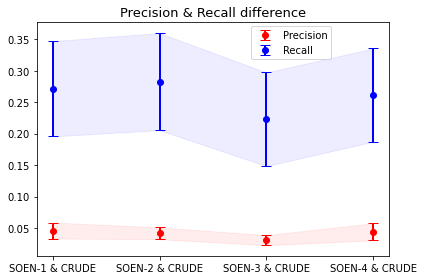

In [195]:
# prec, recall
diff_mean = []
diff_ci = []
for i0 in range(4):
    diff_mean.append(np.mean(np.array(all_result_prec).reshape(4,M,K,10)[0,:,:,i0+2].ravel() - np.array(all_result_prec).reshape(4,M,K,10)[0,:,:,0].ravel()))
    diff_ci.append((np.var(np.array(all_result_prec).reshape(4,M,K,10)[0,:,:,i0+2].ravel() - np.array(all_result_prec).reshape(4,M,K,10)[0,:,:,0].ravel(), ddof = 1)**0.5) * 1.96 / (10))
    diff_mean.append(np.mean(np.array(all_result_rec).reshape(4,M,K,10)[0,:,:,i0+2].ravel() - np.array(all_result_rec).reshape(4,M,K,10)[0,:,:,0].ravel()))
    diff_ci.append((np.var(np.array(all_result_rec).reshape(4,M,K,10)[0,:,:,i0+2].ravel() - np.array(all_result_rec).reshape(4,M,K,10)[0,:,:,0].ravel(), ddof = 1)**0.5) * 1.96 / (10))
    
diff_mean = np.array(diff_mean).reshape(4,2).T
diff_ci = np.array(diff_ci).reshape(4,2).T

from matplotlib.transforms import ScaledTranslation

xx = list(["SOEN-1 & CRUDE","SOEN-2 & CRUDE","SOEN-3 & CRUDE","SOEN-4 & CRUDE"])
fig, ax = plt.subplots()

trans1 = ax.transData + ScaledTranslation(0, 0, fig.dpi_scale_trans)
trans2 = ax.transData + ScaledTranslation(0, 0, fig.dpi_scale_trans)

lw_size = 2

p1 = ax.errorbar(xx, diff_mean[0,:], diff_ci[0,:], linestyle = "none", transform = trans1,
                 label = "Precision", marker = 'o', capsize = 5, lw = lw_size, color = "red")
ax.fill_between(xx, diff_mean[0,:] - diff_ci[0,:], diff_mean[0,:] + diff_ci[0,:], alpha = plt_alpha, color = "red", transform = trans1)

p2 = ax.errorbar(xx, diff_mean[1,:], diff_ci[1,:], linestyle = "none", transform = trans2,
                 label = "Recall", marker = 'o', capsize = 5, lw = lw_size, color = "blue")
ax.fill_between(xx, diff_mean[1,:] - diff_ci[1,:], diff_mean[1,:] + diff_ci[1,:], alpha = plt_alpha, color = "blue", transform = trans1)

handles, labels = ax.get_legend_handles_labels()
plt.title("Precision & Recall difference", fontsize = 13)
ax.legend(bbox_to_anchor=(0.85, 0.82))
fig.tight_layout()
plt.show()

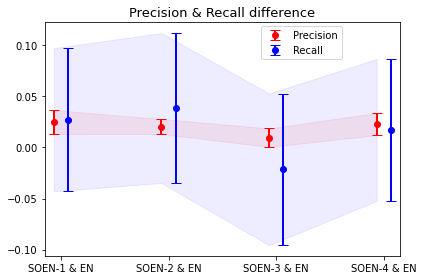

In [196]:
# prec, recall
diff_mean = []
diff_ci = []
for i0 in range(4):
    diff_mean.append(np.mean(np.array(all_result_prec).reshape(4,M,K,10)[0,:,:,i0+2].ravel() - np.array(all_result_prec).reshape(4,M,K,10)[0,:,:,1].ravel()))
    diff_ci.append((np.var(np.array(all_result_prec).reshape(4,M,K,10)[0,:,:,i0+2].ravel() - np.array(all_result_prec).reshape(4,M,K,10)[0,:,:,1].ravel(), ddof = 1)**0.5) * 1.96 / (10))
    diff_mean.append(np.mean(np.array(all_result_rec).reshape(4,M,K,10)[0,:,:,i0+2].ravel() - np.array(all_result_rec).reshape(4,M,K,10)[0,:,:,1].ravel()))
    diff_ci.append((np.var(np.array(all_result_rec).reshape(4,M,K,10)[0,:,:,i0+2].ravel() - np.array(all_result_rec).reshape(4,M,K,10)[0,:,:,1].ravel(), ddof = 1)**0.5) * 1.96 / (10))
    
diff_mean = np.array(diff_mean).reshape(4,2).T
diff_ci = np.array(diff_ci).reshape(4,2).T

from matplotlib.transforms import ScaledTranslation

xx = list(["SOEN-1 & EN","SOEN-2 & EN","SOEN-3 & EN","SOEN-4 & EN"])
fig, ax = plt.subplots()

trans1 = ax.transData + ScaledTranslation(-0.1, 0, fig.dpi_scale_trans)
trans2 = ax.transData + ScaledTranslation(+0.1, 0, fig.dpi_scale_trans)

lw_size = 2

p1 = ax.errorbar(xx, diff_mean[0,:], diff_ci[0,:], linestyle = "none", transform = trans1,
                 label = "Precision", marker = 'o', capsize = 5, lw = lw_size, color = "red")
ax.fill_between(xx, diff_mean[0,:] - diff_ci[0,:], diff_mean[0,:] + diff_ci[0,:], alpha = plt_alpha, color = "red", transform = trans1)

p2 = ax.errorbar(xx, diff_mean[1,:], diff_ci[1,:], linestyle = "none", transform = trans2,
                 label = "Recall", marker = 'o', capsize = 5, lw = lw_size, color = "blue")
ax.fill_between(xx, diff_mean[1,:] - diff_ci[1,:], diff_mean[1,:] + diff_ci[1,:], alpha = plt_alpha, color = "blue", transform = trans1)

handles, labels = ax.get_legend_handles_labels()
plt.title("Precision & Recall difference", fontsize = 13)
ax.legend(bbox_to_anchor=(0.85, 0.82))
fig.tight_layout()
plt.show()

## Figure 12

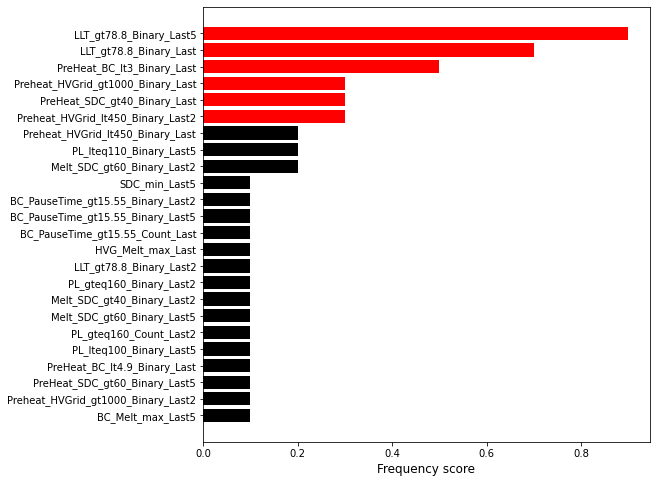

In [201]:
for ii in range(4):
    aaaa = []
    for i0 in range(10):
        SOEN_table = np.unique(sum(list(np.array(All_feat_SOEN_OOB).reshape(4, M, N)[ii, i0, :]), []), return_counts = True)
        varvar = SOEN_table[0][SOEN_table[1] >= N*SOEN_threshold]
        aaaa.append(list(varvar))

temp_mat = np.unique(sum(aaaa, []), return_counts= True)

profit_color = [{p<0.3: 'black', p>=0.3: 'red'}[True] for p in np.sort(temp_mat[1]) / M]

plt.figure(figsize = (8,8))
plt.barh(temp_mat[0][temp_mat[1].argsort()],
         np.sort(temp_mat[1]) / M, 
         color = profit_color)
plt.xlabel("Frequency score", fontsize = 12)
plt.show()

## Table-7 (~ 20 sec)

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import StratifiedKFold

import imblearn




names = [
    "Linear SVM",
    "RBF SVM",
    "KNN",
    "Decision Tree",
    "AdaBoost",
    
    "Random Forest",
    "ExtraTrees",
    "Gaussian Process",
    "Naive Bayes",
    "QDA",
    
    "Neural Net",
    "LightGBM",
    "Logistic Regression",
    "LASSO",
    "RIDGE",   
]

classifiers = [
    SVC(kernel = "linear", random_state = 0),
    SVC(random_state = 0),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state = 0),
    AdaBoostClassifier(random_state = 0),
    
    RandomForestClassifier(random_state = 0), 
    ExtraTreesClassifier(random_state = 0),
    GaussianProcessClassifier(random_state = 0),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    
    MLPClassifier(random_state = 0),
    LGBMClassifier(random_state = 0),
    LogisticRegression(random_state= 0),
    Lasso(random_state = 0, alpha = 0.01),
    Ridge(random_state = 0)
]

result_f1 = []
result_f2 = []
result_f3 = []
result_f4 = []
result_prec = []
result_rec = []

var_list = layerDF.columns[1:]
var_list = ["LLT_gt78.8_Binary_Last5",
           "LLT_gt78.8_Binary_Last",
           "PreHeat_BC_lt3_Binary_Last",
            "Preheat_HVGrid_gt1000_Binary_Last",
           "PreHeat_SDC_gt40_Binary_Last",
           "Preheat_HVGrid_lt450_Binary_Last2"]

n_fold = 5

for name, clf in zip(names, classifiers):
    skf = StratifiedKFold(n_splits = n_fold)
    X, y = layerDF[var_list], layerDF["y"].astype("int")
    skf.get_n_splits(X, y)
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = list(y[train_index]), list(y[test_index])
        
        res = imblearn.over_sampling.SMOTE(random_state = 0)
        X_train_over, y_train_over = res.fit_resample(X_train, y_train)
    
        clf.fit(X_train_over, y_train_over)
        
        if name in ["Logistic Regression", "LASSO", "RIDGE"]:
            temp_pred = clf.predict(X_train_over)
            opt_threshold = optimalThreshold_Gmeans(y_train_over, temp_pred)
            
            pred = clf.predict(X_test)
            pred = list(map(bool, pred >= opt_threshold))
        
        else:
            pred = clf.predict(X_test)
        
        result_f1.append(fbeta_score(y_test, pred, beta = 1))
        result_f2.append(fbeta_score(y_test, pred, beta = 2))
        result_f3.append(fbeta_score(y_test, pred, beta = 3))
        result_f4.append(fbeta_score(y_test, pred, beta = 4))
        
        result_prec.append(precision_score(y_test, pred))
        result_rec.append(recall_score(y_test, pred))
        
        
df = [list(np.array(result_rec).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_prec).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_f1).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_f2).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_f3).reshape(15,n_fold).mean(axis = 1)),
      list(np.array(result_f4).reshape(15,n_fold).mean(axis = 1))]

df = np.around(df, 4).T

df = pd.DataFrame(np.array(df),
                 columns = ["Recall",
                          "Precision",
                          "F-score (beta = 1)", 
                          "F-score (beta = 2)", 
                          "F-score (beta = 3)", 
                          "F-score (beta = 4)"],
             index = names)
df

,Recall,Precision,F-score (beta = 1),F-score (beta = 2),F-score (beta = 3),F-score (beta = 4)
Linear SVM,0.6667,0.2469,0.2793,0.3435,0.4075,0.4611
RBF SVM,0.4667,0.2627,0.1919,0.2211,0.2663,0.3067
KNN,0.0667,0.2000,0.1000,0.0769,0.0714,0.0694
Decision Tree,0.2667,0.0968,0.1297,0.1738,0.2032,0.2218
AdaBoost,0.4000,0.0979,0.1481,0.2279,0.2861,0.3225
Random Forest,0.2667,0.0917,0.1239,0.1689,0.1997,0.2193
ExtraTrees,0.2667,0.0940,0.1267,0.1714,0.2017,0.2208
Gaussian Process,0.6667,0.2506,0.2839,0.3482,0.4113,0.4641
Naive Bayes,0.8667,0.2420,0.2714,0.3338,0.4047,0.4735
QDA,1.0000,0.0180,0.0354,0.0840,0.1550,0.2377


## Figure 13

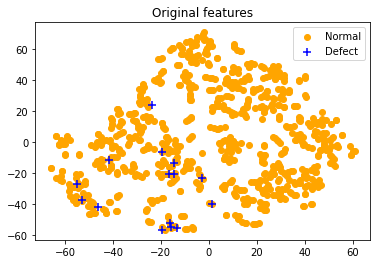

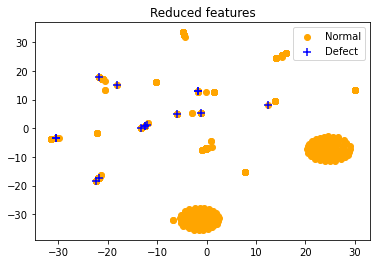

In [204]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, 
            perplexity = 8,
            random_state = 0,
            n_iter = 777)

X = layerDF[var_list]
y = layerDF["y"]
X_tsne = tsne.fit_transform(X) 
plt.title("Original features")
plt.scatter(X_tsne[y == 0, 0],
            X_tsne[y == 0, 1],
           color = "orange",
            label = "Normal")

plt.scatter(X_tsne[y == 1, 0],
            X_tsne[y == 1, 1],
           color = "blue",
           marker = "+",
            label = "Defect",
           s = 50)
plt.legend()
plt.show()
#############################################################


X = layerDF[temp_mat[0][temp_mat[1].argsort()[::-1]][:6]]
y = layerDF["y"]

X_tsne = tsne.fit_transform(X) 

plt.title("Reduced features")
plt.scatter(X_tsne[y == 0, 0],
            X_tsne[y == 0, 1],
           color = "orange",
           label = "Normal")

plt.scatter(X_tsne[y == 1, 0],
            X_tsne[y == 1, 1],
            color = "blue",
            marker = "+",
            label = "Defect",
            s = 50)
plt.legend()
plt.show()